In [140]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sentence_transformers import SentenceTransformer


In [141]:
class KNNHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    """
    Scikit-learn compatible KNN-based hate speech classifier using sentence-transformer embeddings.
    
    Args:
        threshold (float): Probability threshold for binary classification.
        model_name (str): SentenceTransformer model to use.
        n_neighbors (int): Number of neighbors for KNN.
        precomputed (bool): Whether input to fit/predict is already embedded.
    """

    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2', n_neighbors=5, precomputed=False):
        self.threshold = threshold
        self.model_name = model_name
        self.n_neighbors = n_neighbors
        self.precomputed = precomputed
        self.embedder = SentenceTransformer(model_name)
        self.scaler = StandardScaler()
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    def fit(self, X, y):
        self.knn.set_params(n_neighbors=self.n_neighbors)
        if self.precomputed:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.fit_transform(X_emb)
        self.knn.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        if self.precomputed:
            X_scaled = self.scaler.transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.transform(X_emb)
        return self.knn.predict_proba(X_scaled)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == np.array(y))

    def get_embeddings(self, texts, scale=True):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        embeddings = self.embedder.encode(texts, show_progress_bar=False)
        if scale:
            return self.scaler.fit_transform(embeddings)
        return embeddings

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Hate", "Hate"],
                    yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def show_misclassifications(self, X, y_true, y_pred):
        X = pd.Series(X)
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)
        mismatches = X[y_true != y_pred]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))
        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))

    def plot_roc_curve(self, X, y_true):
        probs = self.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - KNN Hate Speech Classifier")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [142]:
base_dir =  os.getcwd()
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")
train_path = os.path.join(base_dir, "../data/train_data.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].tolist()
test_labels = test_df["isHate"].tolist()


In [143]:
model = KNNHateSpeechClassifier()
X_train = model.get_embeddings(train_texts, scale=True)
X_test = model.scaler.transform(model.embedder.encode(test_texts))
param_grid = {'n_neighbors': list(range(1, 7)), 'threshold': [0.2, 0.3, 0.4, 0.5, 0.6]}

custom_scorer = make_scorer(f1_score)
grid = GridSearchCV(
    KNNHateSpeechClassifier(precomputed=True),
    param_grid={'n_neighbors': list(range(1, 7)), 'threshold': [0.2, 0.3, 0.4, 0.5, 0.6]},
    scoring=custom_scorer,
    cv=3
)
grid.fit(X_train, train_labels)

print("Best Threshold:", grid.best_params_['threshold'])
print("Best n_neighbors:", grid.best_params_['n_neighbors'])
best_model = grid.best_estimator_
preds = best_model.predict(X_test)
print(classification_report(test_labels, preds))


Best Threshold: 0.4
Best n_neighbors: 6
              precision    recall  f1-score   support

           0       0.72      0.53      0.61       475
           1       0.66      0.81      0.73       523

    accuracy                           0.68       998
   macro avg       0.69      0.67      0.67       998
weighted avg       0.69      0.68      0.67       998



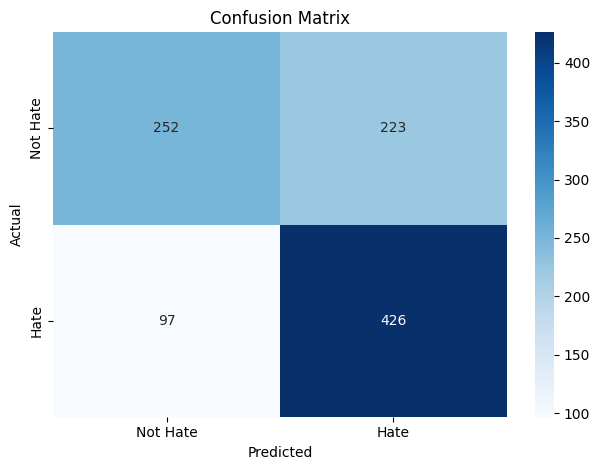


FALSE POSITIVES:
I don't see why we don't just create a transgen...
You guys I fell so bad, I hope this don’t happe...
Yet there is vastly more money spent on breast ...
What would the abuser doing to her around the n...
Well this is like exactly how I feel. Except I ...

FALSE NEGATIVES:
Who do you think you are cunt? wtf! Stay steady...
This sick, disgusting, white terrorist/fascist ...
This Korean bitch is like a pig. That’s how the...
These women aren't autistic, they are smart, au...
She said is christian. Well I now I want to bur...


In [144]:
best_model.plot_confusion_matrix(test_labels, preds)
best_model.show_misclassifications(test_texts, test_labels, preds)

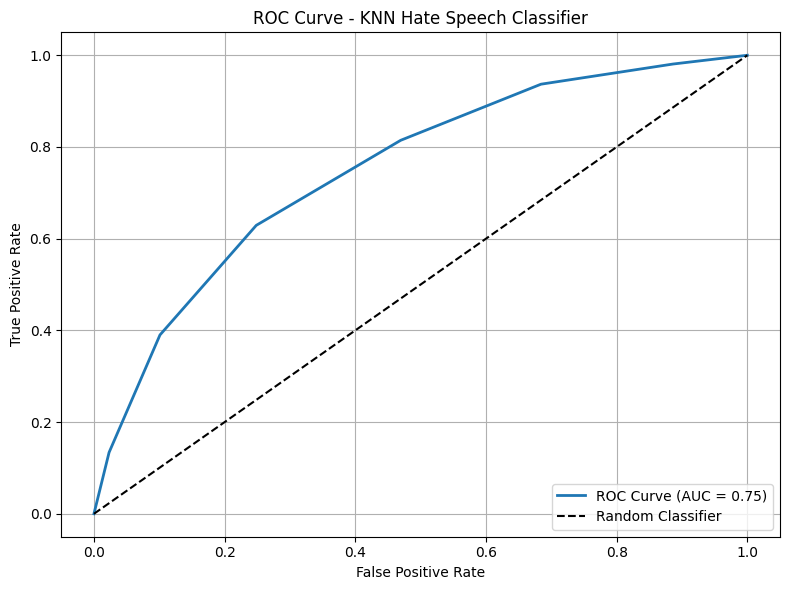

In [145]:
best_model.plot_roc_curve(X_test, test_labels)

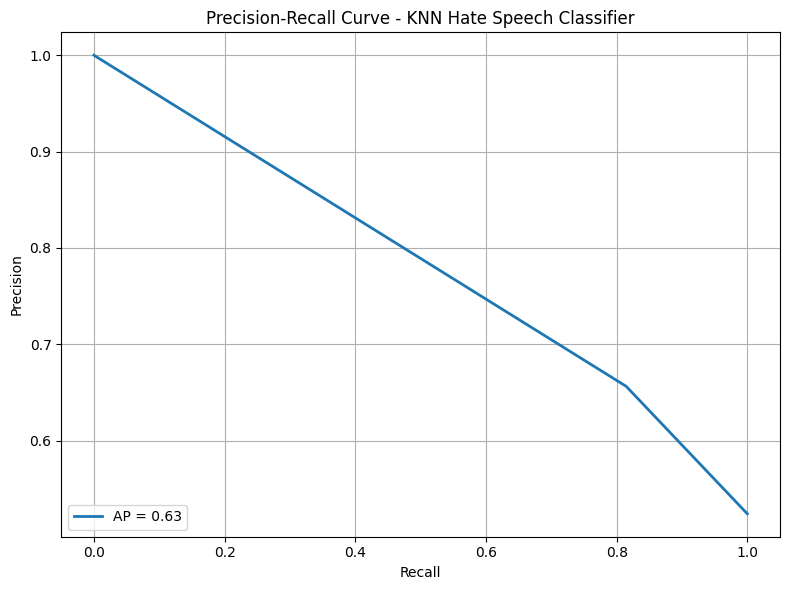

In [146]:
precision, recall, _ = precision_recall_curve(test_labels, preds)
avg_precision = average_precision_score(test_labels, preds)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN Hate Speech Classifier')
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()